In [14]:
%matplotlib inline
import logging
import Euclid
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u

from collections import namedtuple
from glob import glob
from matplotlib import colors
from astropy.table import Table, Column
from tqdm.notebook import tqdm
from scipy.stats import gaussian_kde

%elogin
%erun PHZ_NNPZ

sys.path.append('/home/aalvarez/Work/Projects/PHZ_NNPZ/PHZ_NNPZ/nnpz/python/')

%load_ext autoreload
%autoreload 2
from nnpz.reference_sample.ReferenceSample import ReferenceSample
from nnpz.photometry.ListFileFilterProvider import ListFileFilterProvider
from nnpz.photometry.FnuuJyPrePostProcessor import FnuuJyPrePostProcessor
from nnpz.photometry.FnuPrePostProcessor import FnuPrePostProcessor
from nnpz.photometry.FlambdaPrePostProcessor import FlambdaPrePostProcessor
from nnpz.photometry.ReferenceSampleParallelPhotometryBuilder import ReferenceSamplePhotometryParallelBuilder as PhotometryBuilder

plt.rcParams['figure.figsize'] = (20, 10)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
class TqdmWrapper(object):
    def __init__(self, total):
        self.tqdm = tqdm(total=total)
        self.progress = 0
        
    def __call__(self, n):
        self.tqdm.update(n - self.progress)
        self.progress = n
        
Iter = namedtuple('Iter', ['sed'])

In [3]:
from SimSpectra.SimSpectra import SimGalaxySpectra
from ST_DM_MDBTools.Mdb import Mdb

In [4]:
spec = SimGalaxySpectra(
    sedlib_filename='/home/aalvarez/Work/Data/SC8/TU/Lib/EUC-TEST-GSEDLIB-2015-03-18T171100.000.fits',
    filter_filename='/home/aalvarez/Work/Data/SC8/TU/Lib/EUC-TEST-FILSDSSR01-2015-02-02T203100.000.fits',
    extlib_filename='/home/aalvarez/Work/Data/SC8/TU/Lib/EUC-TEST-GEXTLAWLIB-2015-03-18T203100.000.fits',
    extmap_filename=[
        '/home/aalvarez/Work/Data/SC8/TU/Lib/SFD_dust_1024_ngp.fits',
        '/home/aalvarez/Work/Data/SC8/TU/Lib/SFD_dust_1024_sgp.fits',
    ],
    norm_sed='AB.sed',
    wmin=4700E-10,
    wmax=24500E-10,
    nwl=2000
)

INFO    : Use internal AB reference spectrum
2020-08-17T14:42:04CEST SimSpectra  INFO : Use internal AB reference spectrum


In [5]:
tu = Table.read('/home/aalvarez/Work/Data/SC8/PHZ_MER_TU.fits')
tu.remove_column('Z_OBS_2')
tu.rename_column('Z_OBS_1', 'Z_OBS')

In [6]:
def get_spectra(obj):
    spectra = spec.get_spectra(
        ra=float(obj['RA_MAG']), dec=float(obj['DEC_MAG']), refmag=float(obj['TU_MAG_R01_SDSS']), absmag=float(obj['TU_MAG_R01_SDSS_ABS']),
        z=float(obj['Z_OBS']), ised=float(obj['SED_TEMPLATE']), ebv=float(obj['EBV']), extlaw=float(obj['EXT_LAW']), vacuum=True,
        lines={
            'halpha': float(obj['HALPHA_LOGFLAM_EXT']),
            'hbeta': float(obj['HBETA_LOGFLAM_EXT']),
            'O2': float(obj['O2_LOGFLAM_EXT']),
            'O3': float(obj['O3_LOGFLAM_EXT']),
            'N2': float(obj['N2_LOGFLAM_EXT']),
            'S2': float(obj['S2_LOGFLAM_EXT'])
        },
    )
    # Spectra is in Watts
    spectra *= 1e-7
    return np.stack([spec.wgrid.to(u.Angstrom).value, spectra], axis=-1)

spectra = get_spectra(tu[500])

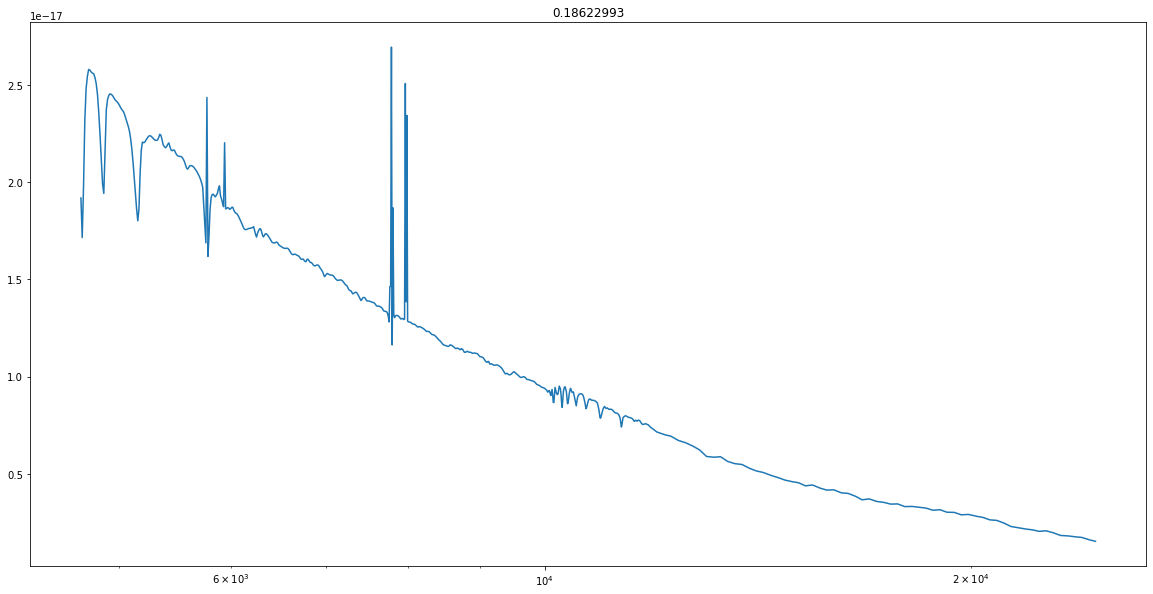

In [7]:
plt.figure()
plt.title(tu[500]['Z_OBS'])
plt.plot(spectra[:,0], spectra[:,1])
plt.xscale('log')

# Photometry for IB

In [8]:
# Filter Provider
subaru_trans_files = glob('/home/aalvarez/Phosphoros/AuxiliaryData/Filters/Subaru/IB*.dat') + glob('/home/aalvarez/Phosphoros/AuxiliaryData/Filters/euclid/*.dat')
with open('/tmp/filter_list.txt', 'wt') as fd:
    fd.write('\n'.join(subaru_trans_files))
filter_provider = ListFileFilterProvider('/tmp/filter_list.txt')

# Photometry
fnuu = FnuuJyPrePostProcessor()

In [9]:
# Builder
photo_builder = PhotometryBuilder(filter_provider, fnuu, ncores=4)

In [27]:
def sed_from_tu():
    for obj in tu:
        yield Iter(sed=get_spectra(obj))

In [28]:
ret = photo_builder.buildPhotometry(sed_from_tu(), progress_listener=TqdmWrapper(len(tu)))

INFO    : Computing photometries using 4 processes
2020-08-17T14:46:41CEST BuildPhotometry  INFO : Computing photometries using 4 processes


**NOTE**: SC8 Cycle 3 mock catalogs are in Jy

In [31]:
output_table = Table([tu['OBJECT_ID']] + list(map(lambda v: Column(data=v[1]/1e6, name=v[0]), ret.items())))

In [32]:
output_table.write('/home/aalvarez/Work/Data/SC8/GalaxyIB.fits', overwrite=True)